In [4]:
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from IPython.display import Image
from qutip import (Qobj, about, basis, Bloch, Bloch3d, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, sigmam, sigmap, tensor, thermal_dm, sesolve, spre, spost, sprepost, to_super)
from qutip.qip.operations import hadamard_transform as HD, rx, ry, rz
from qutip.ipynbtools import plot_animation
from scipy.optimize import curve_fit
%matplotlib widget
plt.rc('font', size=16)         # Set the default text font size
plt.rc('axes', titlesize=16)    # Set the axes title font size
plt.rc('axes', labelsize=16)    # Set the axes labels font size
plt.rc('xtick', labelsize=16)   # Set the font size for x tick labels
plt.rc('ytick', labelsize=16)   # Set the font size for y tick labels
plt.rc('legend', fontsize=18)   # Set the legend font size
plt.rc('figure', titlesize=20)  # Set the font size of the figure title
plt.rc('lines', linewidth=3)    # Set the default linewidth
plt.rc("text", usetex=False)

#Adjusting the way to write some of the functions because I'm lazy
σx = sigmax
σy = sigmay
σz = sigmaz
I = qeye
Sx = σx()/2
Sy = σy()/2
Sz = σz()/2

In [51]:
def FM(t, A, v1, p1, v2, p2, DC, d):
    return A *np.exp(d*t)*np.cos(p1+v1*np.sin(v2*t+p2))+DC

def expFit(t, A, d, DC):
    return A*np.exp(-d*t)+DC


def H2(t: float, args: dict):

    ϵ = args["eps"]
    νp = args["vp"]
    Ωx = args["omegaX"]
    δν = args["dv"]
    return -(ϵ-νp)*Sz - 2*Ωx*np.cos(δν*t)*Sx

In [64]:
dvmin = 0.001
dvmax = 0.1
ndv = 15
dvs = np.linspace(dvmin, dvmax, ndv)
vp = 5.0
Ωx = 0.0633
ϵ = 5.0
tmax = 5000
nt = 5
ψ0 = basis(2, 0)
c_ops = [np.sqrt(0.00001)*sigmam(), np.sqrt(0.0001)*sigmaz()]
times = np.linspace(0, tmax, nt*tmax)
v1s = []
v2s = []
dvdata = []
for dv in dvs:
    print(f"RUNNING: dv={dv}GHz")
    result = mesolve(H2, ψ0, times, c_ops=c_ops, e_ops=[], args=dict(eps=ϵ, vp=vp, omegaX=Ωx, dv=dv))
    states = np.array(result.states)
    zero = states[:,0,0]
    f1 = (1+4*Ωx)/(10*dv)
    f2 = dv
    try:
        pop, pcov = curve_fit(FM, result.times, zero, [0.5, f1, 0, f2, 0, 0.5, d])
    except RunTimeError:
        print(f"\t{dv}GHz FAILED!")
        continue
    v1s.append(pop[1])
    v2s.append(pop[3])
    dvdata.append(dv)


RUNNING: dv=0.001GHz
RUNNING: dv=0.008071428571428571GHz
RUNNING: dv=0.015142857142857142GHz
RUNNING: dv=0.022214285714285714GHz
RUNNING: dv=0.029285714285714286GHz
RUNNING: dv=0.03635714285714286GHz
RUNNING: dv=0.04342857142857143GHz
RUNNING: dv=0.0505GHz
RUNNING: dv=0.05757142857142857GHz
RUNNING: dv=0.06464285714285714GHz
RUNNING: dv=0.07171428571428572GHz
RUNNING: dv=0.07878571428571429GHz
RUNNING: dv=0.08585714285714285GHz
RUNNING: dv=0.09292857142857143GHz
RUNNING: dv=0.1GHz


Frequencies: f1=7.8325000000000005, f2=0.016
[ 5.00267851e-01  7.91250181e+00 -1.39747039e-03  1.59999947e-02
  6.05324306e-05  5.00000509e-01 -1.25349013e-04]


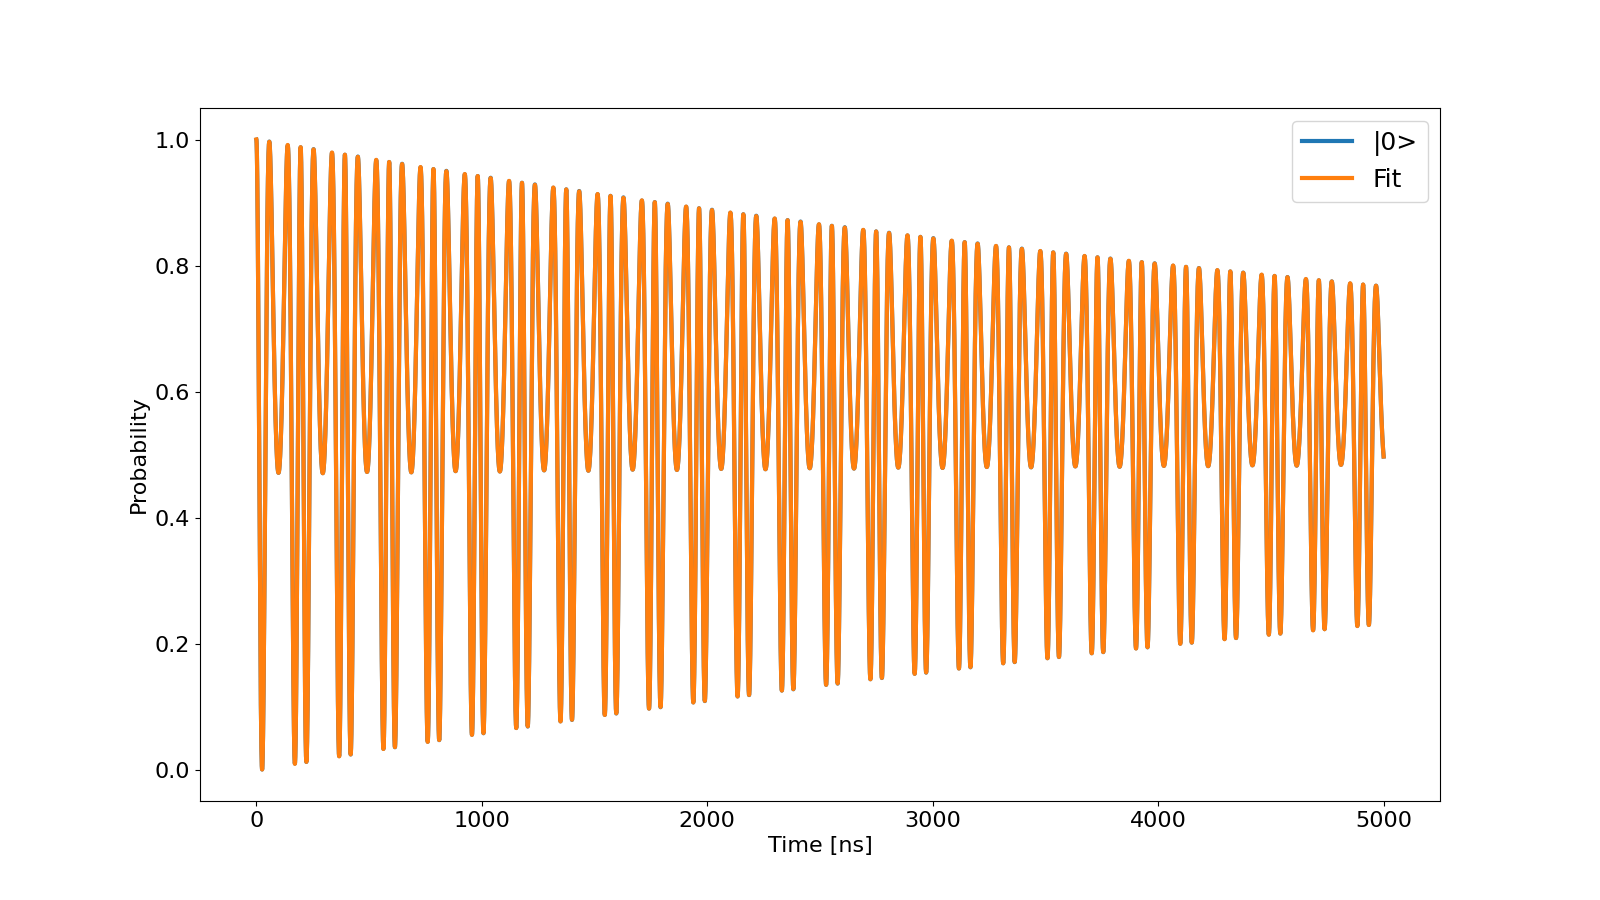

In [60]:
fig, ax = plt.subplots(figsize=(16,9))

f1 = (1+4*Ωx)/(10*δν)
f2 = δν
print(f"Frequencies: f1={f1}, f2={f2}")
d=-0.0001
lim=-1
ax.plot(result.times[:lim], zero[:lim], label="|0>")
pop, pcov = curve_fit(FM, result.times, zero, [0.5, f1, 0, f2, 0, 0.5, d])
print(pop)
ax.plot(result.times[:lim], FM(result.times[:lim], *pop), label="Fit")
# ax.plot(result.times[:lim], 0.5*np.exp(d*t)
ax.set_ylabel("Probability")
ax.set_xlabel("Time [ns]")
ax.legend()

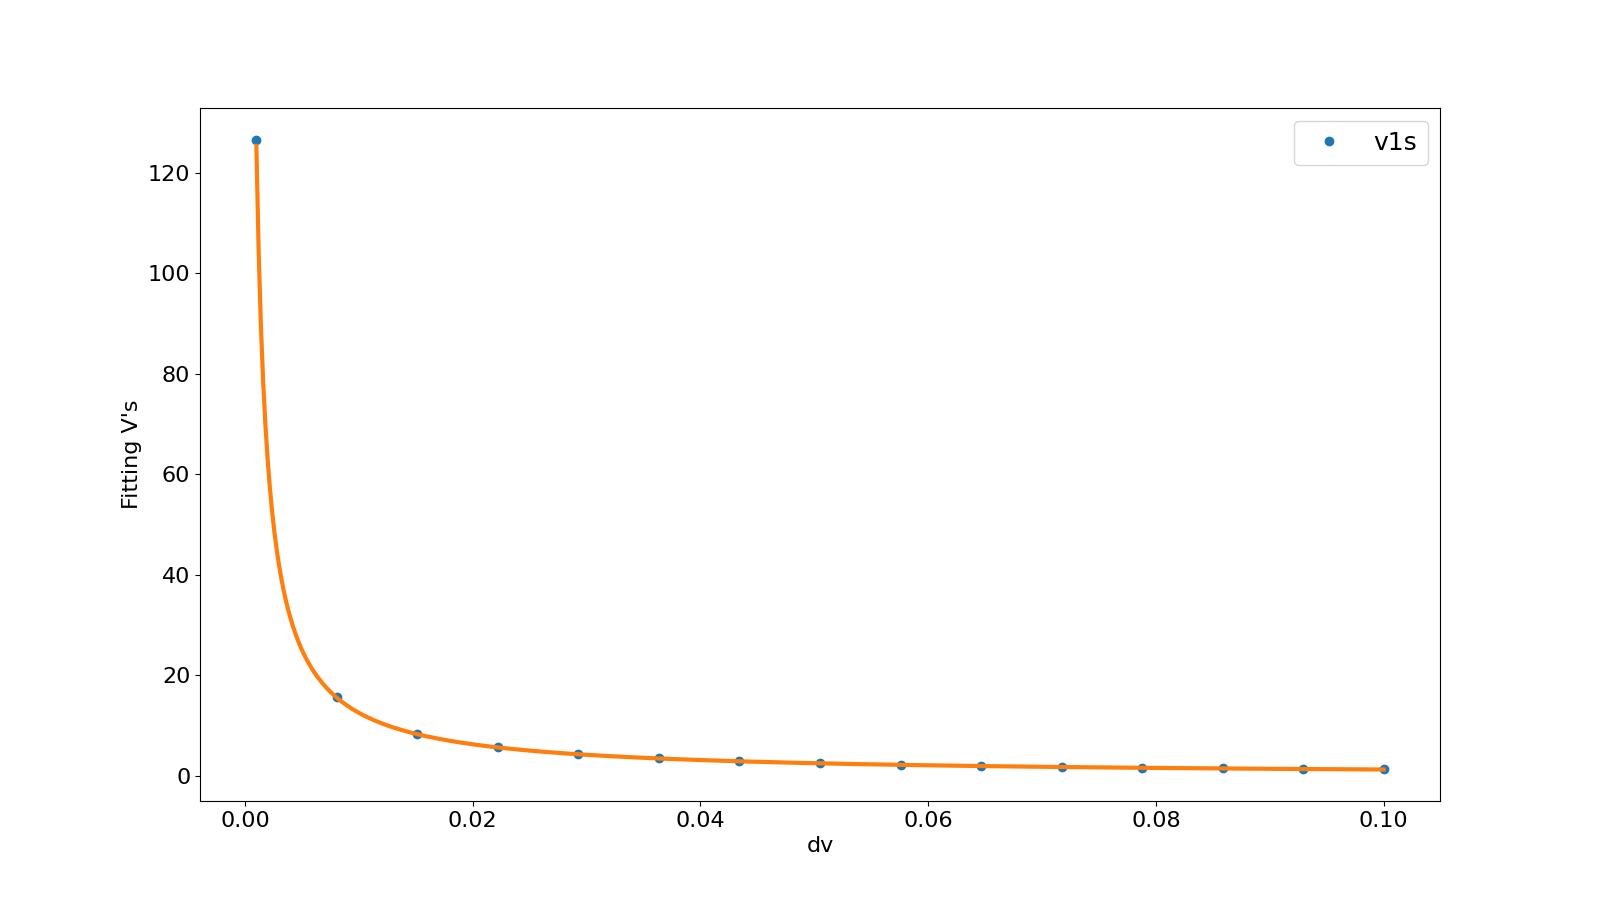

In [74]:
fig, ax = plt.subplots(figsize=(16,9))
dvdata = np.array(dvdata)
dvtest = np.linspace(0.001, 0.1, 500)
ax.plot(dvdata, v1s, "o", label="v1s")
ax.plot(dvtest, (1+4*Ωx)/(10*dvtest))
# ax.plot(dvdata, v2s, label="v2s")
ax.set_xlabel("dv")
ax.set_ylabel("Fitting V's")
ax.legend()

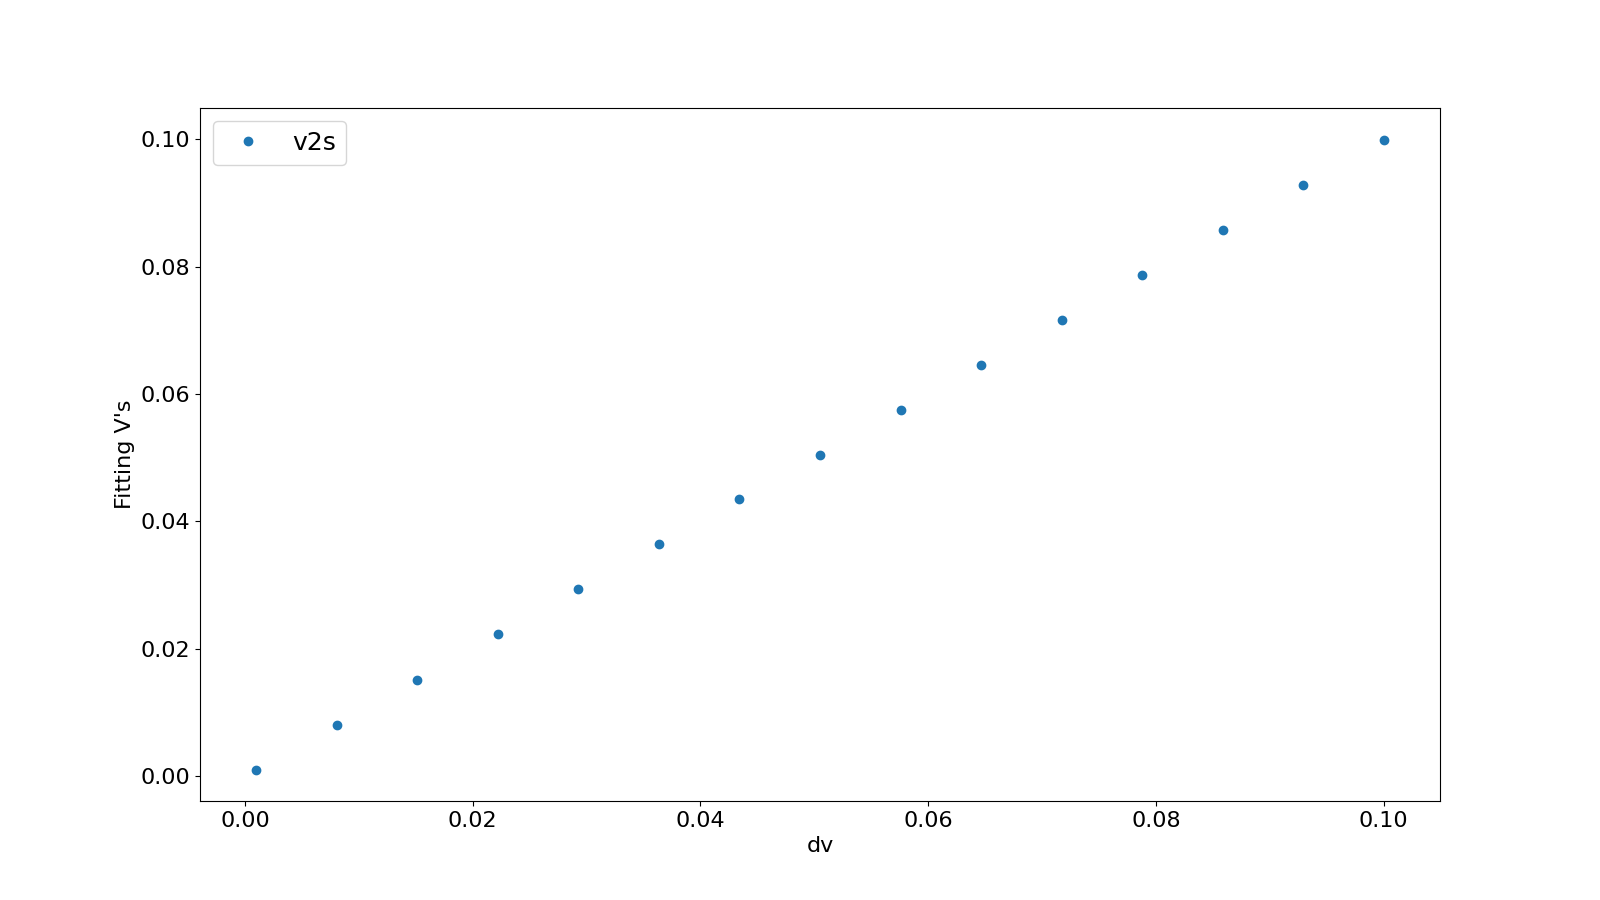

In [69]:
fig, ax = plt.subplots(figsize=(16,9))
# ax.plot(dvdata, v1s, label="v1s")
ax.plot(dvdata, v2s, "o", label="v2s")
ax.set_xlabel("dv")
ax.set_ylabel("Fitting V's")
ax.legend()